In [150]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import brier_score_loss
import sys; sys.path.append('../')
from src.pipelines import EmbedCalibrate
from src.postprocessing import TemperatureScaling
from src.supcon import ContrastiveLoss
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Moons decisions boundaries

In [145]:
def sample(seed=None, dim=2):
    np.random.seed(seed)
    # More noise in the moons makes the task harder
    X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.3)

    # Rescale and shift the dataset to better fit into zero-one box
    X = (X + 1.6) / 4
    X[:, 0] = X[:, 0] - 0.035
    X[:, 1] = (X[:, 1] - 0.17) * 1.75
    # y = tf.one_hot(y, depth=2)
    
    return X, y

X_train, y_train = sample(1)
X_test, y_test = sample(2)

In [146]:
def plot(clf, plot_min, plot_max, max_prob, title):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    probs = clf.predict_proba(points)
    
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y_train)
    X0 = X_train[y_np==0]
    X1 = X_train[y_np==1]
    plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
                marker='o', linewidths=0.2)
    plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
                marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
#     plt.savefig('figures/moons_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
#         plot_min, plot_max, max_prob), transparent=True)
    plt.show()

KNN o ContrastNN (Honest)


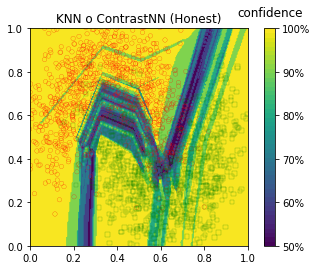

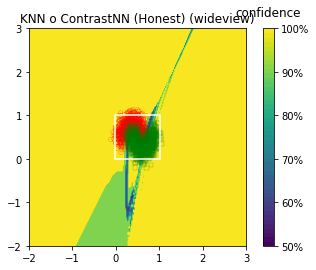

Softmax


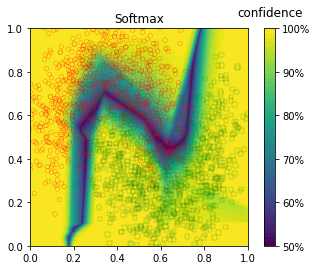

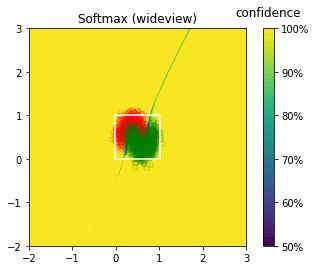

Softmax (Temp scaling)


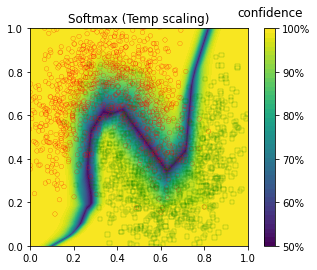

../src/postprocessing.py:20: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x)
../src/postprocessing.py:21: RuntimeWarning: invalid value encountered in true_divide
  return e_x / e_x.sum(axis=1, keepdims=1)


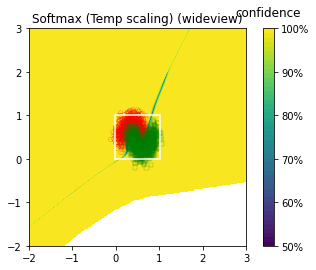

KNN o NN


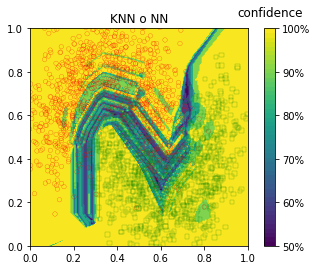

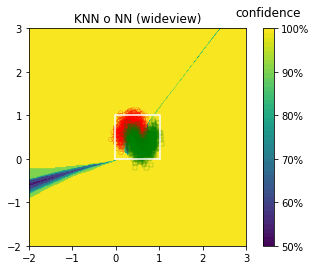

KNN o NN (Honest)


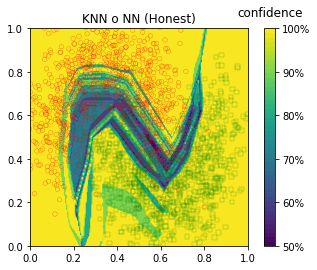

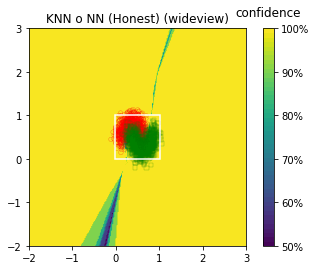

In [147]:
batch_size = 10

# Initialize network for softmax loss
network_softmax = keras.Sequential()
network_softmax.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_softmax.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_softmax.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_softmax.add(layers.Dense(2, bias_initializer="glorot_uniform"))
network_softmax.add(layers.Activation('softmax'))

softmax_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": "acc",
}

# Initialize network for contrastive loss
network_contrastive = keras.Sequential()
network_contrastive.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_contrastive.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_contrastive.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_contrastive.add(layers.Dense(2, bias_initializer="glorot_uniform"))

contrastive_kwargs = {
    "loss": ContrastiveLoss(),
    "optimizer": keras.optimizers.Adam(1e-2),
}

knn = KNeighborsClassifier(n_neighbors=10)
temp_scalar = TemperatureScaling()

fit_kwargs = {
    "epochs": 200,
    "batch_size": batch_size,
    "verbose": False
}

clfs = [
    (EmbedCalibrate(network_contrastive, contrastive_kwargs, fit_kwargs, -2, knn, validation_frac=0.3), 'KNN o ContrastNN (Honest)'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs), 'Softmax'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -2, temp_scalar, validation_frac=0.1), 'Softmax (Temp scaling)'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=None), 'KNN o NN'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o NN (Honest)'),
]

for clf, name in clfs:
    print(name)
    clf = clf.fit(X_train, y_train)
    plot(clf, 0.0, 1.0, max_prob=True, title=f'{name}')
    plot(clf, -2.0, 3.0, max_prob=True, title=f'{name} (wideview)')

### Moons calibration curves

Softmax:
	Brier: 0.070
	F1: 0.905

Softmax (Temp scaling):
	Brier: 0.072
	F1: 0.902

KNN o NN:
	Brier: 0.074
	F1: 0.904

KNN o NN (Honest):
	Brier: 0.073
	F1: 0.904



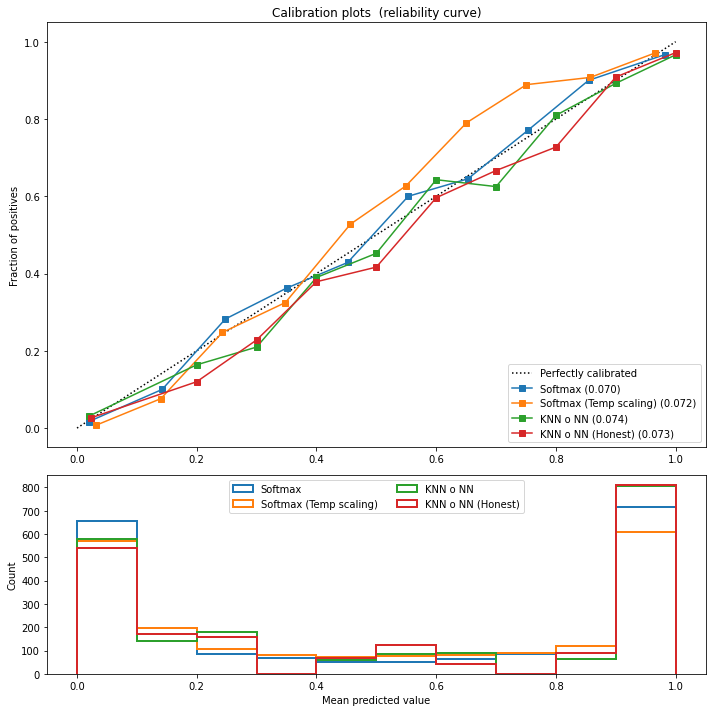

In [134]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, f1_score

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Initialize network
network = keras.Sequential()
network.add(keras.Input(shape=(2,)))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(units=2))
network.add(layers.Activation('softmax'))

knn = KNeighborsClassifier(n_neighbors=10)
temp_scalar = TemperatureScaling()

compile_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": "acc",
}
fit_kwargs = {
    "epochs": 200,
    "batch_size": 32,
    "verbose": False
}

clfs = [
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs), 'Softmax'),
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs, -2, temp_scalar, validation_frac=0.1), 'Softmax (Temp scaling)'),
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs, -3, knn, validation_frac=None), 'KNN o NN'),
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o NN (Honest)'),
]
for clf, name in clfs:
    clf = clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)

    prob_pos = probs[:, 1]
    y_pred = np.argmax(probs, axis=1)

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

## Gaussian blob posteriors

In [165]:
from sklearn.model_selection import train_test_split

n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = datasets.make_blobs(n_samples=n_samples, centers=centers, shuffle=False,
                  random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

batch_size = 50

# Initialize network for softmax loss
network_softmax = keras.Sequential()
network_softmax.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_softmax.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_softmax.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_softmax.add(layers.Dense(2, bias_initializer="glorot_uniform"))
network_softmax.add(layers.Activation('softmax'))

softmax_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": "acc",
}

# Initialize network for contrastive loss
network_contrastive = keras.Sequential()
network_contrastive.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_contrastive.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
network_contrastive.add(layers.Dense(100, activation='relu', bias_initializer="glorot_uniform"))
# network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))
network_contrastive.add(layers.Dense(2, bias_initializer="glorot_uniform"))#, activation='relu'))
# network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))

contrastive_kwargs = {
    "loss": ContrastiveLoss(),
    "optimizer": keras.optimizers.Adam(1e-2),
}

knn = KNeighborsClassifier(n_neighbors=20)
temp_scalar = TemperatureScaling()

fit_kwargs = {
    "epochs": 100,
    "batch_size": batch_size,
    "verbose": False
}

# pos_probs = {}
clfs = [
    (EmbedCalibrate(network_contrastive, contrastive_kwargs, fit_kwargs, -1, knn, validation_frac=0.3), 'KNN o ContrastNN (Honest)'),
    # (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs), 'Softmax'),
    # (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -2, temp_scalar, validation_frac=0.1), 'Softmax (Temp scaling)'),
    # (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=None), 'KNN o NN'),
    # (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o NN (Honest)'),
]

for clf, name in clfs:
    print(name)
    clf = clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)

    pos_probs[name] = probs[:, 1]

KNN o ContrastNN (Honest)


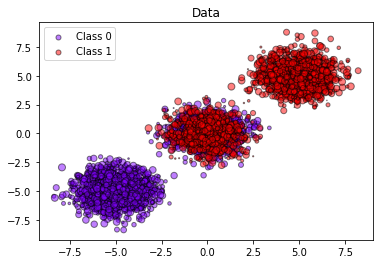

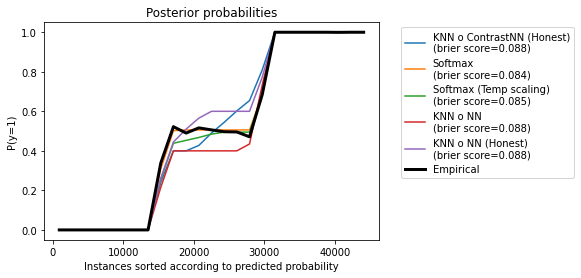

In [166]:
# #############################################################################
# Plot the data and the predicted probabilities
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()

for name, probs in pos_probs.items():
    order = np.lexsort((probs, ))
    score = brier_score_loss(y_test, probs, sample_weight=sw_test)
    plt.plot(np.linspace(0, y_test.size, 51)[1::2],
             probs[order].reshape(25, -1).mean(1), label=f'{name}\n(brier score={score:.3f})')
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability")
plt.ylabel("P(y=1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.title("Posterior probabilities")

plt.show()

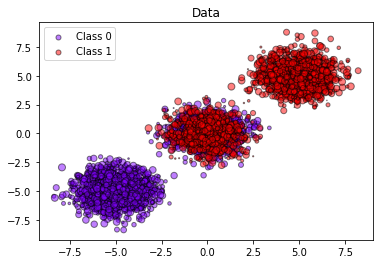

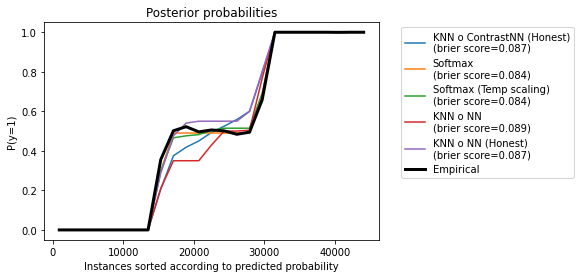

In [151]:
# #############################################################################
# Plot the data and the predicted probabilities
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()

for name, probs in pos_probs.items():
    order = np.lexsort((probs, ))
    score = brier_score_loss(y_test, probs, sample_weight=sw_test)
    plt.plot(np.linspace(0, y_test.size, 51)[1::2],
             probs[order].reshape(25, -1).mean(1), label=f'{name}\n(brier score={score:.3f})')
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability")
plt.ylabel("P(y=1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.title("Posterior probabilities")

plt.show()

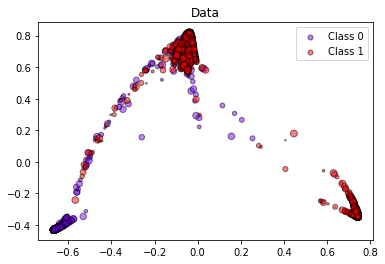

In [152]:
X_plot = clfs[0][0].transformer_(X_train)

from sklearn.decomposition import PCA
X_plot = PCA(n_components=2).fit_transform(X_plot)

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_plot[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

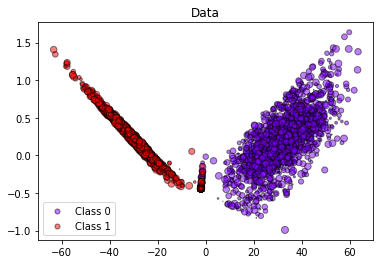

In [265]:
X_plot = clfs[1][0].transformer_(X_train)

from sklearn.decomposition import PCA
X_plot = PCA(n_components=2).fit_transform(X_plot)

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_plot[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

In [535]:
def polytope_activations(model, x):
    activations = []
    for layer in model.layers:
        x = layer(x)
        if hasattr(layer, 'activation'):
            if layer.activation == tf.keras.activations.relu:
                act = (x.numpy() > 0).astype(int)
                activations.append(act)
            elif layer.activation == tf.keras.activations.softmax:
                act = (x.numpy() > 0.5).astype(int)
                activations.append(act)

    return activations

def plot_decision_boundaries(clf, X, y, layer_indices=None, n_activations=None, xlim=None, ylim=None, n_pts=100):
    if hasattr(clf, 'network_'):
        model = clf.network_
    else:
        model = clf
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(*list(zip(*X)), c=y, cmap='RdBu', alpha=0.25)

    # plot the decision function
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], n_pts)
    yy = np.linspace(ylim[0], ylim[1], n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    # plot linear region boundaries
    # activations = polytope_membership(model, XY)
    activations = polytope_activations(model, XY)
    colors = ['red', 'blue', 'black']
    if layer_indices is None:
        acts = np.hstack(activations)
        Z = np.unique(acts, axis=0, return_inverse=True)[1].reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=colors[0], alpha=0.5)
    else:
        for c, i in zip(colors, layer_indices):
            acts = activations[i]
            Z = np.unique(acts, axis=0, return_inverse=True)[1].reshape(XX.shape)
            plt.contour(XX, YY, Z, colors=c, alpha=0.5)
    
    if hasattr(clf, 'predict_proba'):
        probs = clf.predict_proba(XY)

        z_plot = probs.max(1)
        z_plot = z_plot.reshape(XX.shape)

        vmax = 100
        vmin = 50
        plt.contourf(XX, YY, z_plot, alpha=0.2)#, levels=np.linspace(50, 100, 50))
        cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))

        cbar.ax.set_title('confidence', fontsize=12, pad=12)
        cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])

    plt.show()

In [319]:
n_samples = 2000
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.1)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

batch_size=100

# Initialize network for contrastive loss
network_softmax = keras.Sequential()
network_softmax.add(keras.layers.InputLayer((2,)))#, batch_size=batch_size))
network_softmax.add(layers.Dense(10, bias_initializer="glorot_uniform", activation='relu'))
# network_contrastive.add(layers.Activation('relu'))
network_softmax.add(layers.Dense(10, bias_initializer="glorot_uniform", activation='relu'))
# network_contrastive.add(layers.Activation('relu'))
network_softmax.add(layers.Dense(2, bias_initializer="glorot_uniform"))#, activation='relu'))
# network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))
network_softmax.add(layers.Activation('softmax'))

softmax_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": 'acc',
}

fit_kwargs = {
    "epochs": 200,
    "batch_size": batch_size,
    # "verbose": False
}

clf_softmax = EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs)
clf_softmax = clf_softmax.fit(X, y)

Epoch 1/200
20/20 [==============================] - 0s 665us/step - loss: 0.6884 - acc: 0.6241
Epoch 2/200
20/20 [==============================] - 0s 764us/step - loss: 0.4317 - acc: 0.8527
Epoch 3/200
20/20 [==============================] - 0s 703us/step - loss: 0.2761 - acc: 0.8618
Epoch 4/200
20/20 [==============================] - 0s 791us/step - loss: 0.2582 - acc: 0.8747
Epoch 5/200
20/20 [==============================] - 0s 838us/step - loss: 0.2791 - acc: 0.8733
Epoch 6/200
20/20 [==============================] - 0s 704us/step - loss: 0.2693 - acc: 0.8690
Epoch 7/200
20/20 [==============================] - 0s 801us/step - loss: 0.2549 - acc: 0.8801
Epoch 8/200
20/20 [==============================] - 0s 910us/step - loss: 0.2520 - acc: 0.8781
Epoch 9/200
20/20 [==============================] - 0s 781us/step - loss: 0.2689 - acc: 0.8609
Epoch 10/200
20/20 [==============================] - 0s 655us/step - loss: 0.2513 - acc: 0.8814
Epoch 11/200
20/20 [===================

20/20 [==============================] - 0s 754us/step - loss: 0.2295 - acc: 0.8932
Epoch 86/200
20/20 [==============================] - 0s 762us/step - loss: 0.2529 - acc: 0.8765
Epoch 87/200
20/20 [==============================] - 0s 792us/step - loss: 0.2247 - acc: 0.8929
Epoch 88/200
20/20 [==============================] - 0s 729us/step - loss: 0.2365 - acc: 0.8825
Epoch 89/200
20/20 [==============================] - 0s 724us/step - loss: 0.2185 - acc: 0.8920
Epoch 90/200
20/20 [==============================] - 0s 701us/step - loss: 0.2244 - acc: 0.8908
Epoch 91/200
20/20 [==============================] - 0s 686us/step - loss: 0.2175 - acc: 0.8894
Epoch 92/200
20/20 [==============================] - 0s 697us/step - loss: 0.2287 - acc: 0.8971
Epoch 93/200
20/20 [==============================] - 0s 691us/step - loss: 0.2136 - acc: 0.8889
Epoch 94/200
20/20 [==============================] - 0s 686us/step - loss: 0.2139 - acc: 0.8916
Epoch 95/200
20/20 [=======================

20/20 [==============================] - 0s 752us/step - loss: 0.0099 - acc: 0.9987
Epoch 169/200
20/20 [==============================] - 0s 725us/step - loss: 0.0086 - acc: 0.9985
Epoch 170/200
20/20 [==============================] - 0s 745us/step - loss: 0.0086 - acc: 0.9983
Epoch 171/200
20/20 [==============================] - 0s 703us/step - loss: 0.0123 - acc: 0.9983
Epoch 172/200
20/20 [==============================] - 0s 713us/step - loss: 0.0115 - acc: 0.9972
Epoch 173/200
20/20 [==============================] - 0s 721us/step - loss: 0.0116 - acc: 0.9970
Epoch 174/200
20/20 [==============================] - 0s 706us/step - loss: 0.0088 - acc: 0.9973
Epoch 175/200
20/20 [==============================] - 0s 705us/step - loss: 0.0079 - acc: 0.9998
Epoch 176/200
20/20 [==============================] - 0s 706us/step - loss: 0.0112 - acc: 0.9958
Epoch 177/200
20/20 [==============================] - 0s 727us/step - loss: 0.0142 - acc: 0.9962
Epoch 178/200
20/20 [=============

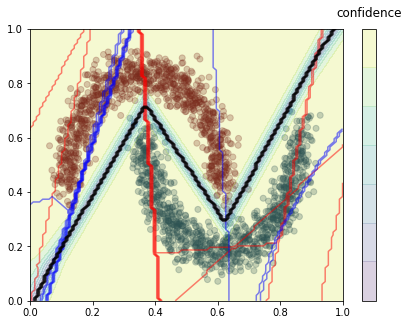

In [421]:
plot_decision_boundaries(clf_softmax, X, y, [0, 1, 2], xlim=[0, 1], ylim=[0, 1])

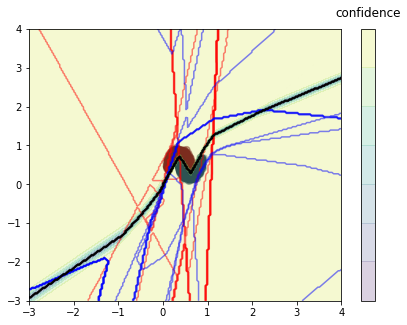

In [423]:
plot_decision_boundaries(clf_softmax, X, y, [0, 1, 2], xlim=[-3, 4], ylim=[-3, 4], n_pts=200)

In [303]:
n_samples = 2000
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.1)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

batch_size=100

# Initialize network for contrastive loss
network_contrastive = keras.Sequential()
network_contrastive.add(keras.layers.InputLayer((2,)))#, batch_size=batch_size))
network_contrastive.add(layers.Dense(10, activation='relu', bias_initializer="glorot_uniform"))
network_contrastive.add(layers.Dense(10, activation='relu', bias_initializer="glorot_uniform"))
network_contrastive.add(layers.Dense(2, bias_initializer="glorot_uniform"))#, activation='relu'))
# network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))
# network_contrastive.add(layers.Activation('softmax'))

contrastive_kwargs = {
    "loss": ContrastiveLoss(),
    "optimizer": keras.optimizers.Adam(1e-2),
    # "metrics": 'acc',
}

knn = KNeighborsClassifier(n_neighbors=10)

fit_kwargs = {
    "epochs": 200,
    "batch_size": batch_size,
    "verbose": False
}

clf_contrastive = EmbedCalibrate(network_contrastive, contrastive_kwargs, fit_kwargs, -1, knn, validation_frac=0.3)
clf_contrastive = clf_contrastive.fit(X, y)

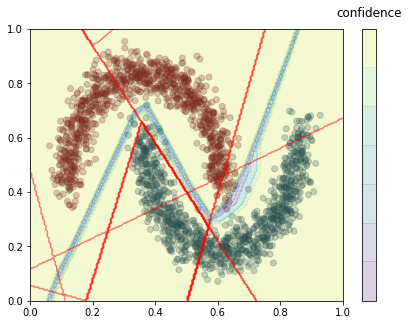

In [424]:
plot_decision_boundaries(clf_contrastive, X, y, [0], xlim=[0, 1], ylim=[0, 1], n_pts=200)

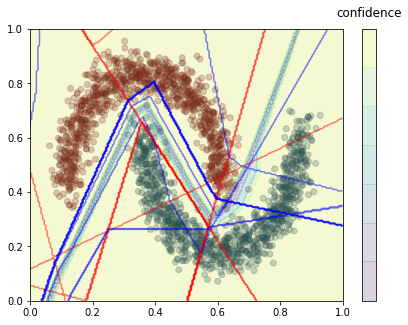

In [426]:
plot_decision_boundaries(clf_contrastive, X, y, [0, 1], xlim=[0, 1], ylim=[0, 1], n_pts=200)

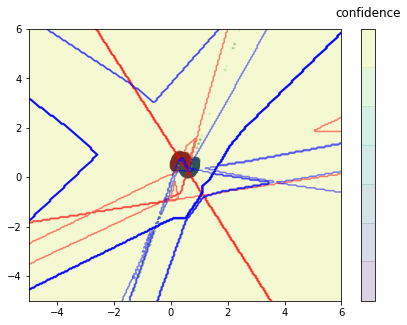

In [427]:
plot_decision_boundaries(clf_contrastive, X, y, [0, 1], xlim=[-5, 6], ylim=[-5, 6], n_pts=200)

### Margin loss

In [507]:
from src.losses import softmax_loss, margin_loss
from src.models import ReluNet

In [571]:
n_samples = 2000
# More noise in the moons makes the task harder
X_train, y_train = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.1)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box
X_train = (X_train + 1.6) / 4
X_train[:, 0] = X_train[:, 0] - 0.035
X_train[:, 1] = (X_train[:, 1] - 0.17) * 1.75

network_margin = ReluNet([4])#, 10])#, 2], out_act=tf.nn.softmax)

optimizer = keras.optimizers.Adam(1e-2)
batch_size = 100

# Training loop
epochs = 100
temp = 1#0.0001

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.astype(np.float32), y_train)#tf.one_hot(y_train, depth=len(np.unique(y_train))))
).shuffle(len(X)).batch(batch_size)

_ = network_margin(X[:1])
for i in range(1, epochs+1):
    for X, y in train_dataset:
        with tf.GradientTape() as tape:
            # logits = network_margin(X)
            # loss = softmax_loss(out, y, temp=temp)
            margins = network_margin.margin_distances(X)
            activations = network_margin.activations(X)
            loss = margin_loss(margins, activations, y)
            grads = tape.gradient(loss, network_margin.trainable_weights)
            optimizer.apply_gradients(zip(grads, network_margin.trainable_weights))
#     if i % 10  == 0:
#         logits = network_margin(X_train)
#         train_err = np.mean(tf.nn.softmax(logits / temp).numpy().argmax(1) != y_train)
#         print("Iter {:03d}: loss={:.3f} err={:.2%}".format(i, loss, train_err))

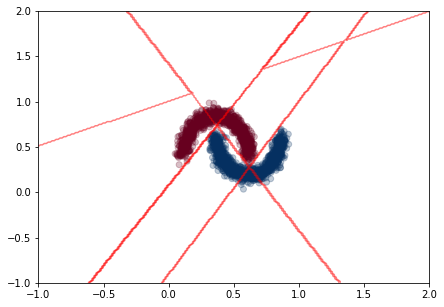

In [556]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=None, xlim=[-1, 2], ylim=[-1, 2], n_pts=200)

In [578]:
X_train = np.random.uniform(-1, 1, (1000, 2))

In [592]:
n_samples = 2000
# More noise in the moons makes the task harder
X_train = np.random.uniform(-1, 1, (1000, 2))
y_train = np.abs(np.sign(X_train).sum(axis=1) / 2).astype(int)

network_margin = ReluNet([2])

optimizer = keras.optimizers.Adam(1e-2)
batch_size = 100

# Training loop
epochs = 100
temp = 1#0.0001

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.astype(np.float32), y_train)#tf.one_hot(y_train, depth=len(np.unique(y_train))))
).shuffle(len(X)).batch(batch_size)

_ = network_margin(X[:1])
for i in range(1, epochs+1):
    for X, y in train_dataset:
        with tf.GradientTape() as tape:
            # logits = network_margin(X)
            # loss = softmax_loss(out, y, temp=temp)
            margins = network_margin.margin_distances(X)
            activations = network_margin.activations(X)
            loss = margin_loss(margins, activations, y)
            grads = tape.gradient(loss, network_margin.trainable_weights)
            optimizer.apply_gradients(zip(grads, network_margin.trainable_weights))
#     if i % 10  == 0:
#         logits = network_margin(X_train)
#         train_err = np.mean(tf.nn.softmax(logits / temp).numpy().argmax(1) != y_train)
#         print("Iter {:03d}: loss={:.3f} err={:.2%}".format(i, loss, train_err))

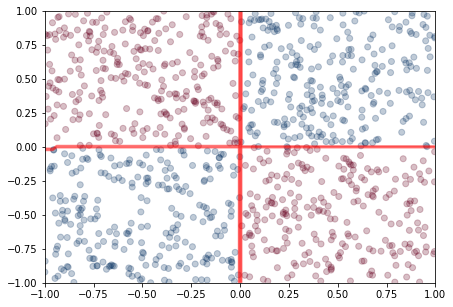

In [594]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=None, xlim=[-1, 1], ylim=[-1, 1], n_pts=100)

In [618]:
def spiral(n=100):
    N = n
    from numpy import pi
    theta = np.sqrt(np.random.rand(N)) * 2 * pi  # np.linspace(0,2*pi,100)

    r_a = 2*theta + pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + np.random.randn(N, 2)

    r_b = -2*theta - pi
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + np.random.randn(N, 2)

    res_a = np.append(x_a, np.zeros((N, 1)), axis=1)
    res_b = np.append(x_b, np.ones((N, 1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    return np.vstack((x_a, x_b)), np.hstack(([0]*len(x_a), [1]*len(x_b)))

In [670]:
n_samples = 500
# More noise in the moons makes the task harder
X_train, y_train = spiral(n_samples)#datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.3)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box

network_margin = ReluNet([20, 20])#, 2], out_act=tf.nn.softmax)

optimizer = keras.optimizers.Adam(1e-3)
batch_size = 50

# Training loop
epochs = 200

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.astype(np.float32), y_train)#tf.one_hot(y_train, depth=len(np.unique(y_train))))
).shuffle(len(X)).batch(batch_size)

_ = network_margin(X[:1])
for i in range(1, epochs+1):
    for X, y in train_dataset:
        with tf.GradientTape() as tape:
            # logits = network_margin(X)
            # loss = softmax_loss(out, y, temp=temp)
            margins = network_margin.margin_distances(X)
            activations = network_margin.activations(X)
            loss = margin_loss(margins, activations, y)
            grads = tape.gradient(loss, network_margin.trainable_weights)
            optimizer.apply_gradients(zip(grads, network_margin.trainable_weights))
#     if i % 10  == 0:
#         logits = network_margin(X_train)
#         train_err = np.mean(tf.nn.softmax(logits / temp).numpy().argmax(1) != y_train)
#         print("Iter {:03d}: loss={:.3f} err={:.2%}".format(i, loss, train_err))

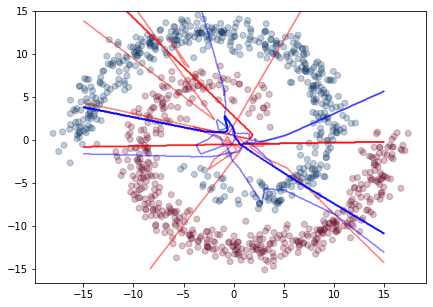

In [671]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=[0, 1], xlim=[-15, 15], ylim=[-15, 15], n_pts=400)

In [666]:
n_samples = 2000
# More noise in the moons makes the task harder
X_train, y_train = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.3)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box
X_train = (X_train + 1.6) / 4
X_train[:, 0] = X_train[:, 0] - 0.035
X_train[:, 1] = (X_train[:, 1] - 0.17) * 1.75

network_margin = ReluNet([4, 4])#, 10])#, 2], out_act=tf.nn.softmax)

optimizer = keras.optimizers.Adam(1e-3)
batch_size = 100

# Training loop
epochs = 200
temp = 1#0.0001

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.astype(np.float32), y_train)#tf.one_hot(y_train, depth=len(np.unique(y_train))))
).shuffle(len(X)).batch(batch_size)

_ = network_margin(X[:1])
for i in range(1, epochs+1):
    for X, y in train_dataset:
        with tf.GradientTape() as tape:
            # logits = network_margin(X)
            # loss = softmax_loss(out, y, temp=temp)
            margins = network_margin.margin_distances(X)
            activations = network_margin.activations(X)
            loss = margin_loss(margins, activations, y)
            grads = tape.gradient(loss, network_margin.trainable_weights)
            optimizer.apply_gradients(zip(grads, network_margin.trainable_weights))
#     if i % 10  == 0:
#         logits = network_margin(X_train)
#         train_err = np.mean(tf.nn.softmax(logits / temp).numpy().argmax(1) != y_train)
#         print("Iter {:03d}: loss={:.3f} err={:.2%}".format(i, loss, train_err))

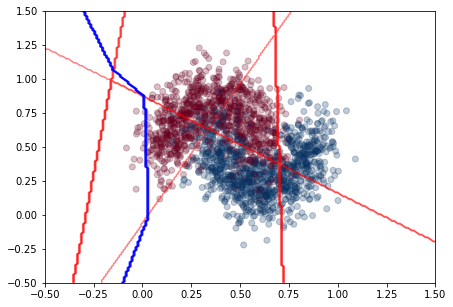

In [667]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=[0, 1], xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], n_pts=200)

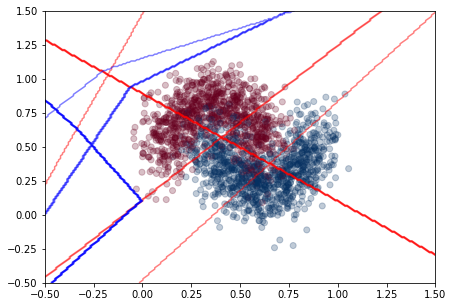

In [601]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=[0, 1], xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], n_pts=200)

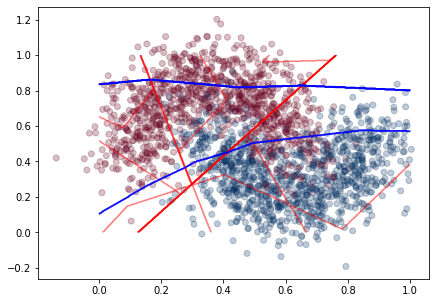

In [566]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=[0, 1], xlim=[0, 1], ylim=[0, 1], n_pts=200)

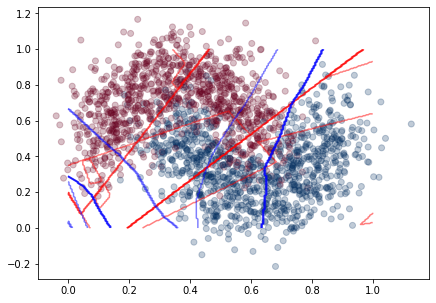

In [570]:
plot_decision_boundaries(network_margin, X_train, y_train, layer_indices=[0, 1], xlim=[0, 1], ylim=[0, 1], n_pts=200)

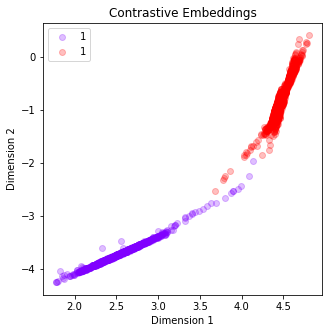

In [428]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None, title=''):
    plt.figure(figsize=(5,5))
    for i in range(len(np.unique(targets))):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.25, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.show()
    
plot_embeddings(clf_contrastive.transformer_(X).numpy(), y, title='Contrastive Embeddings')

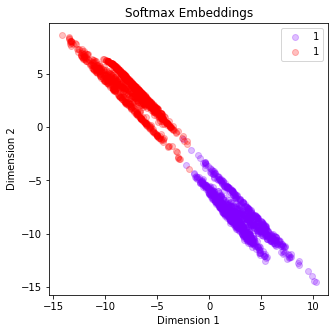

In [429]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None, title=''):
    plt.figure(figsize=(5,5))
    for i in range(len(np.unique(targets))):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.25, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.show()
    
plot_embeddings(clf_softmax.transformer_(X).numpy(), y, title='Softmax Embeddings')